## <p style = "font-size:100%;padding:10px 0px 10px 30px;font-weight: 400;font-family:serifs; letter-spacing: 2px; border: 3px solid yellow; color: brown; background-color:#d3d3d3; border-radius:30px 0px">1.Importing Libraries</p>

In [2]:
import os

import copy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from scipy.stats import shapiro

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold
from sklearn.inspection import permutation_importance

from sklearn import metrics

import joblib
import pickle

from typing import List, Dict, Set

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
gld = Style.BRIGHT + Fore.YELLOW
grn = Style.BRIGHT + Fore.GREEN
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
white = Style.BRIGHT +Fore.WHITE
cyan = Style.BRIGHT +Fore.CYAN
magenta = Style.BRIGHT +Fore.MAGENTA
res = Style.RESET_ALL

plt.rcParams['figure.dpi'] = 800
plt.rcParams['savefig.dpi'] = 800

sns.set(rc={"figure.dpi":800, 'savefig.dpi':800})
sns.set_context('notebook')
sns.set_style("ticks")

font_title = {
    'size': 20,
    'weight': 'bold',  # You can use 'weight' here instead of 'fontweight'
    'color': 'brown',
    'fontfamily': 'serif'
}
font_sub_title = {'family': 'serif',
        'color':  'brown',
        'weight': 'bold',
        'size': 16,
        }
font_label = {'family': 'serif',
        'color':  'brown',
        'weight': 'bold',
        'size': 16,
        }

In [3]:
df = pd.read_csv("data/car_mpg.csv")
df.head()

mpg  cyl   disp   hp    wt   acc  yr  origin  car_type  \
0  18.0    8  307.0  130  3504  12.0  70       1         0   
1  15.0    8  350.0  165  3693  11.5  70       1         0   
2  18.0    8  318.0  150  3436  11.0  70       1         0   
3  16.0    8  304.0  150  3433  12.0  70       1         0   
4  17.0    8  302.0  140  3449  10.5  70       1         0   

                    car_name  
0  chevrolet chevelle malibu  
1          buick skylark 320  
2         plymouth satellite  
3              amc rebel sst  
4                ford torino

In [4]:
# Use a lambda function to check if any value is only alphabetic
df['hp'] = df['hp'].apply(lambda x: x if x.isdecimal() else np.NaN)
df['hp'] = df['hp'].astype("float64")

## <p style = "font-size:100%;padding:10px 0px 10px 30px;font-weight: 400;font-family:serifs; letter-spacing: 2px; border: 3px solid yellow; color: brown; background-color:#d3d3d3; border-radius:30px 0px">2.PreProcessing & Modelling</p>

In [5]:
def preProcess(df:pd.DataFrame, scale:str="yes")-> pd.DataFrame:
    """Encodes object with Label Encoder.
    
    Args: 
        df (DataFrame): This DatFrame is used to for object label encoding. 
        scale    (str): To Scale the data. 
 
    Returns: 
        DataFrame: label Encoded dataframe
        Simply label encodes object attributes.        
    """
    
    df_encoded = df.copy()
    
    # Encoding the object attributes
    label_encoder = LabelEncoder()
    for col in df_encoded.columns:
        if df_encoded[col].dtype == 'object':
            df_encoded[col] = label_encoder.fit_transform(df_encoded[col])
            
    # Create a pipeline with SimpleImputer and StandardScaler
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # You can choose other strategies for imputation
        ('scaler', StandardScaler())
                             ])
            
    # Imputing the Null values with SimpleImputer
    if scale =="yes":
        df_imputed = pd.DataFrame(pipeline.fit_transform(df_encoded), columns=df_encoded.columns)
        print("Data is Imputed and scaled")
        print("-"*80)
    else:    
        simp = SimpleImputer(strategy='mean')
        df_imputed = pd.DataFrame(simp.fit_transform(df_encoded), columns=df_encoded.columns)
        print("Data is Imputed")
        print("-"*80)
    return df_imputed



def model_evaluation(model_score: Dict, N_SPLITS:int, idx:int=0)-> None:
    """Plots Model evaluation results.
    
    Args: 
        model_score (Dict): This Model results dictionary for a metric. 
        N_SPLITS     (int): number of folds used. 
        idx          (int): 0 for validation and 1 for test results. 
 
    Returns: 
        None 
        Simply Plots model eval results on validation data set.         
    """
    
    metric_list = ['r2-square','mae','rmse']
    nm = 'VALIDATION'
    metric_nm = metric_list[idx]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    for keys in model_score.keys():
        ax.plot(model_score[keys]['valid'][metric_nm], label=str(keys), marker=".")
           
        
    ax.set_title(f"{metric_nm.upper()} scores for Each FOLD - {nm}".upper(), fontdict=font_sub_title)
    ax.set_xticks(np.arange(N_SPLITS))
    ax.set_xlabel("FOLD", fontdict=font_label)
    ax.set_ylabel(f"{metric_nm.upper()} Scores", fontdict=font_label)
    ax.tick_params(labelsize=16, labelcolor='brown',width = 4)
    ax.legend()
    plt.tight_layout()
    
    col_name ='Model_Evaluation'+"_"+str(nm) +"_"+str(metric_nm) 
    path = "static/model_plots/"+col_name+".jpg"
    plt.savefig(path, bbox_inches="tight")
    
    plt.show()
    
def model_predict(model_dict:Dict, train_X, train_y,X_test,y_test, N_SPLITS: int, RANDOM_STATE: int)-> Dict:
    
    """Gets Model evaluation results.
    
    Args: 
        model_dict (Dict): This is Dictinary of models to be used for prediction. 
        X     (DataFrame): Independant train data. 
        y    (DataSeries): Dependant train target data. 
        N_SPLITS    (int): Number of splits for Kfold cross validation. 
        RANDOM_STATE(int): Random state for to draw same samples. 
 
    Returns: 
        Dict : model evaluation results 
        Simply get validation results for models used on train data set.         
    """
    
    kf =KFold(n_splits=N_SPLITS,shuffle=True,random_state=RANDOM_STATE)

    model_score ={}
    trained_models = {}

    for keys in model_dict.keys():   
        
        model_score[keys] = {}    
        
        model_score[keys]['valid'] = {'r2-square': [],
                                        'mae': [],
                                        'rmse': []
                                        }
        model_score[keys]['test'] = {'r2-square': [],
                                    'mae': [],
                                    'rmse': []
                                    }
        trained_models[keys] = []
        y_test_pred = np.zeros(len(X_test))
        
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(train_X,train_y)):
            X_train, X_val = train_X.iloc[train_idx], train_X.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx].to_numpy().ravel(), train_y.iloc[val_idx].to_numpy().ravel()
            
            # Each model should have its own instance
            model = copy.deepcopy(model_dict[keys])
            #model = model_dict[keys].__class__()
            
            model_fit = model.fit(X_train,y_train)
            trained_models[keys].append(model_fit)
                        
            y_val_pred  = model_fit.predict(X_val)
            model_score[keys]['valid']['r2-square'].append(metrics.r2_score(y_val,y_val_pred))
            model_score[keys]['valid']['mae'].append(metrics.mean_absolute_error(y_val,y_val_pred))
            model_score[keys]['valid']['rmse'].append(np.sqrt(metrics.mean_squared_error(y_val,y_val_pred)))
            
            y_test_pred += model_fit.predict(X_test)/N_SPLITS
                            

        model_score[keys]['test']['r2-square'].append(metrics.r2_score(y_test,y_test_pred))
        model_score[keys]['test']['mae'].append(metrics.mean_absolute_error(y_test,y_test_pred))
        model_score[keys]['test']['rmse'].append(np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))
            
            
    mean_score = [[],[],[]]
    print("-"*34+"R2      MAE     RMSE"+"-"*14+"R2      MAE     RMSE")
    for keys in model_score.keys():
        val_r2 = np.mean(model_score[keys]['valid']['r2-square'])
        val_mae = np.mean(model_score[keys]['valid']['mae'])
        val_rmse = np.mean(model_score[keys]['valid']['rmse'])
        
        tst_r2 = np.mean(model_score[keys]['test']['r2-square'])
        tst_mae = np.mean(model_score[keys]['test']['mae'])
        tst_rmse = np.mean(model_score[keys]['test']['rmse'])
        
        print(f"{blu}Model : {gld}{keys:>{12}} {blu}Validation : {magenta}{val_r2:.4f}, {val_mae:.4f}, {val_rmse:.4f}  |  {blu}Test : {magenta}{tst_r2:.4f}, {tst_mae:.4f}, {tst_rmse:.4f}{res}") 
        mean_score[0].append(val_r2)
        mean_score[1].append(val_mae)
        mean_score[2].append(val_rmse)
        

    metric_list = ['r2-square','mae','rmse']
    print("-"*80)
    for i in range(len(mean_score)):
        if i == 0:
            m_index = np.argmax(mean_score[i])
        else:
            m_index = np.argmin(mean_score[i])

        best_model = list(model_dict.keys())[m_index]
        best_score = mean_score[i][m_index]
        print(f"For Metric {gld}{metric_list[i]:>{10}} {magenta}Best Model : {best_model}   |  Best Score : {gld}{best_score:.4f}{res}")
        
    return model_score, trained_models


def pickle_model(trained_models:Dict, 
                 directory:str ="models",
                 pickle_name:str="pickled_model", 
                 use:str='pickle' ):
    
    """Creates a directory for pickled model files and saves the pickle files
        and also create pickle files from passed dictionary of models.
    
    Args: 
        trained_models    (Dict): This is Dictinary of models to be used for pickling. 
        directory    (DataFrame): Directory name for creating it. 
        pickle_name (DataSeries): Name of the pickled file of dict of models. 
        use                (int): Number of plits for Kfold cross validation. 
       
    Returns: 
        Dict : Pickled models
        Simply pickles model and loads the pickled model.         
    """

    directory = "models"
    parent_dir = os.getcwd()

    path = os.path.join(parent_dir,directory)
    print(path)
    if not os.path.exists(path):
        os.mkdir(path=path)
        
    print("-"*80)
    print(f"Directory with {red}{directory}{res} name created")
    print("-"*80)
    
    if use == 'pickle':
        pickle_file_path = directory+'/'+pickle_name+'.pkl'
        # Use pickle to save the model
        with open(pickle_file_path, 'wb') as pickle_file:
            pickle.dump(trained_models, pickle_file)
        
        print(f"Model file pickled & SAVED in directory {red}{pickle_file_path}{res}")
        
        # Load the saved list of models using pickle
        with open(pickle_file_path, 'rb') as pickle_file:
            loaded_models_pickle = pickle.load(pickle_file)
            
        print(f"{red}pickle file{res} named {pickle_name} {red}LOADED{res}")
        print("-"*80)

        return loaded_models_pickle
            
    else:
        # Specify the file path where you want to save the models
        joblib_file_path = directory+'/'+pickle_name+'.pkl'
        # Use joblib to save the list of trained models to a pickle file
        joblib.dump(trained_models, joblib_file_path)
        print(f"Joblib SAVED model in file path {red}{joblib_file_path}{res}")
        
        # Load the saved model
        loaded_model_job = joblib.load(joblib_file_path)
        
        print(f"{red}Joblib file{res} named {pickle_name} {red}LOADED{res}")
        print("-"*80)

        return loaded_model_job


In [16]:
def regression_plot(y_true, y_pred,best_model_name:str="rf_reg")-> None:

    fig, ax = plt.subplots(1,2,figsize=(15,6), layout="constrained")

    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    min_val =  min(y_true)
    max_val =  max(y_true)

    sns.scatterplot(x=y_pred,y=y_true, ax = ax[0], s=25, facecolor='#f0ab62', edgecolor='black', linewidth=1.5, label="Actual")
    ax[0].set_title("Regression Plot Predictions", fontdict=font_sub_title)
    ax[0].set_xlabel("mpg Predcited", fontdict=font_label)
    ax[0].set_ylabel("mpg Actual", fontdict=font_label)
    ax[0].tick_params(labelsize = 14, labelcolor="brown", width=2)

    # Add a 45-degree line
    ax[0].plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', linewidth=2, label="Perfectly Predicted")
    ax[0].legend()

    sns.histplot(y_pred, ax =ax[1], color = "black", label = "Predicted", bins = 20)
    sns.histplot(y_true, ax =ax[1], color = "#f0ab62", label = "Actual", bins = 20)
    ax[1].set_title("Distribution Plots", fontdict=font_sub_title)
    ax[1].set_xlabel("mpg", fontdict=font_label)
    ax[1].set_ylabel("Count", fontdict=font_label)
    ax[1].tick_params(labelsize = 14, labelcolor="brown", width=2)
    ax[1].legend()

    plt.tight_layout()
    
    col_name ='Reg_and_dist_plot'+' for '+best_model_name 
    path = "static/model_plots/"+col_name+".jpg"
    plt.savefig(path, bbox_inches="tight")
    
    plt.show()
    
def error_plot(y_true,y_pred,best_model_name:str="rf_reg")-> None:

    fig, ax = plt.subplots(figsize=(15,6), layout="constrained")

    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    y_err = y_true - y_pred

    sns.scatterplot(x=y_pred,y=y_err, ax = ax, s=75, facecolor='#f0ab62', edgecolor='black', linewidth=2, label ="error")
    ax.set_title("Error Distribution Plots", fontdict=font_sub_title)
    ax.set_xlabel("mpg Predcited Values", fontdict=font_label)
    ax.set_ylabel("Error", fontdict=font_label)
    ax.tick_params(labelsize = 14, labelcolor="brown", width=2)

    # Add a horizontal line from x = 0 to x = 10
    ax.hlines(y=0, xmin=min(y_pred)-0.5, xmax=max(y_pred)+0.5, color='green', linestyle='--', linewidth=4, label="actual_line")
    ax.legend()

    plt.tight_layout()
    
    col_name ='Error_plot' +' for '+best_model_name
    path = "static/model_plots/"+col_name+".jpg"
    plt.savefig(path, bbox_inches="tight")
    plt.show()
    


In [7]:
RANDOM_STATE = 42
N_SPLITS = 8

y_col = ['mpg']
x_cols = [col for col in df.columns if col not in y_col]

# Specify columns by data type
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if col not in cat_cols+y_col]

# Models to be used for prediction

model_dict ={
    'linear_reg':LinearRegression(),
    'dt_reg' : DecisionTreeRegressor(random_state=RANDOM_STATE),
    'rf_reg' : RandomForestRegressor(random_state=RANDOM_STATE),
    'histgbm_reg' : HistGradientBoostingRegressor(random_state=RANDOM_STATE),
    'xgb_reg' : xgb.XGBRegressor(random_state=RANDOM_STATE),
    'lgb_reg' : lgb.LGBMRegressor(random_state=RANDOM_STATE)
}

In [8]:
df_preprocessed = preProcess(df[x_cols],scale="no")
X = df_preprocessed[x_cols]
y = df[y_col]

train_X, X_test, train_y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_score, trained_models = model_predict(model_dict=model_dict,
              train_X= train_X,
              train_y=train_y,
              X_test = X_test,
              y_test = y_test,
              N_SPLITS=N_SPLITS,
              RANDOM_STATE=RANDOM_STATE)

Data is Imputed
--------------------------------------------------------------------------------
----------------------------------R2      MAE     RMSE--------------R2      MAE     RMSE
Model :   linear_reg Validation : 0.8186, 2.5429, 3.2933  |  Test : 0.8648, 2.1420, 2.6957
Model :       dt_reg Validation : 0.7578, 2.6269, 3.7652  |  Test : 0.8866, 1.6972, 2.4694
Model :       rf_reg Validation : 0.8546, 2.0446, 2.9303  |  Test : 0.9200, 1.5804, 2.0745
Model :  histgbm_reg Validation : 0.8550, 2.0826, 2.9440  |  Test : 0.9192, 1.5853, 2.0841
Model :      xgb_reg Validation : 0.8367, 2.2180, 3.1181  |  Test : 0.9025, 1.7105, 2.2898
Model :      lgb_reg Validation : 0.8569, 2.1193, 2.9280  |  Test : 0.9154, 1.6208, 2.1326
--------------------------------------------------------------------------------
For Metric  r2-square Best Model : lgb_reg   |  Best Score : 0.8569
For Metric        mae Best Model : rf_reg   |  Best Score : 2.0446
For Metric       rmse Best Model : lgb_reg   |  Best

In [9]:
X

cyl   disp     hp      wt   acc    yr  origin  car_type  car_name
0    8.0  307.0  130.0  3504.0  12.0  70.0     1.0       0.0      49.0
1    8.0  350.0  165.0  3693.0  11.5  70.0     1.0       0.0      36.0
2    8.0  318.0  150.0  3436.0  11.0  70.0     1.0       0.0     231.0
3    8.0  304.0  150.0  3433.0  12.0  70.0     1.0       0.0      14.0
4    8.0  302.0  140.0  3449.0  10.5  70.0     1.0       0.0     161.0
..   ...    ...    ...     ...   ...   ...     ...       ...       ...
393  4.0  140.0   86.0  2790.0  15.6  82.0     1.0       1.0     153.0
394  4.0   97.0   52.0  2130.0  24.6  82.0     2.0       1.0     301.0
395  4.0  135.0   84.0  2295.0  11.6  82.0     1.0       1.0     119.0
396  4.0  120.0   79.0  2625.0  18.6  82.0     1.0       1.0     159.0
397  4.0  119.0   82.0  2720.0  19.4  82.0     1.0       1.0      69.0

[398 rows x 9 columns]

In [10]:
y

mpg
0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
..    ...
393  27.0
394  44.0
395  32.0
396  28.0
397  31.0

[398 rows x 1 columns]

In [11]:
df_preprocessed = preProcess(df[x_cols],scale="yes")
X = df_preprocessed[x_cols]
y = df[y_col]

train_X, X_test, train_y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_score, trained_models = model_predict(model_dict=model_dict,
              train_X= train_X,
              train_y=train_y,
              X_test = X_test,
              y_test = y_test,
              N_SPLITS=N_SPLITS,
              RANDOM_STATE=RANDOM_STATE)

Data is Imputed and scaled
--------------------------------------------------------------------------------
----------------------------------R2      MAE     RMSE--------------R2      MAE     RMSE
Model :   linear_reg Validation : 0.8186, 2.5429, 3.2933  |  Test : 0.8648, 2.1420, 2.6957
Model :       dt_reg Validation : 0.7581, 2.6261, 3.7622  |  Test : 0.8870, 1.6850, 2.4652
Model :       rf_reg Validation : 0.8550, 2.0416, 2.9255  |  Test : 0.9200, 1.5767, 2.0736
Model :  histgbm_reg Validation : 0.8549, 2.0856, 2.9448  |  Test : 0.9192, 1.5858, 2.0843
Model :      xgb_reg Validation : 0.8367, 2.2163, 3.1184  |  Test : 0.9026, 1.7085, 2.2881
Model :      lgb_reg Validation : 0.8556, 2.0940, 2.9393  |  Test : 0.9165, 1.6102, 2.1193
--------------------------------------------------------------------------------
For Metric  r2-square Best Model : lgb_reg   |  Best Score : 0.8556
For Metric        mae Best Model : rf_reg   |  Best Score : 2.0416
For Metric       rmse Best Model : rf_reg

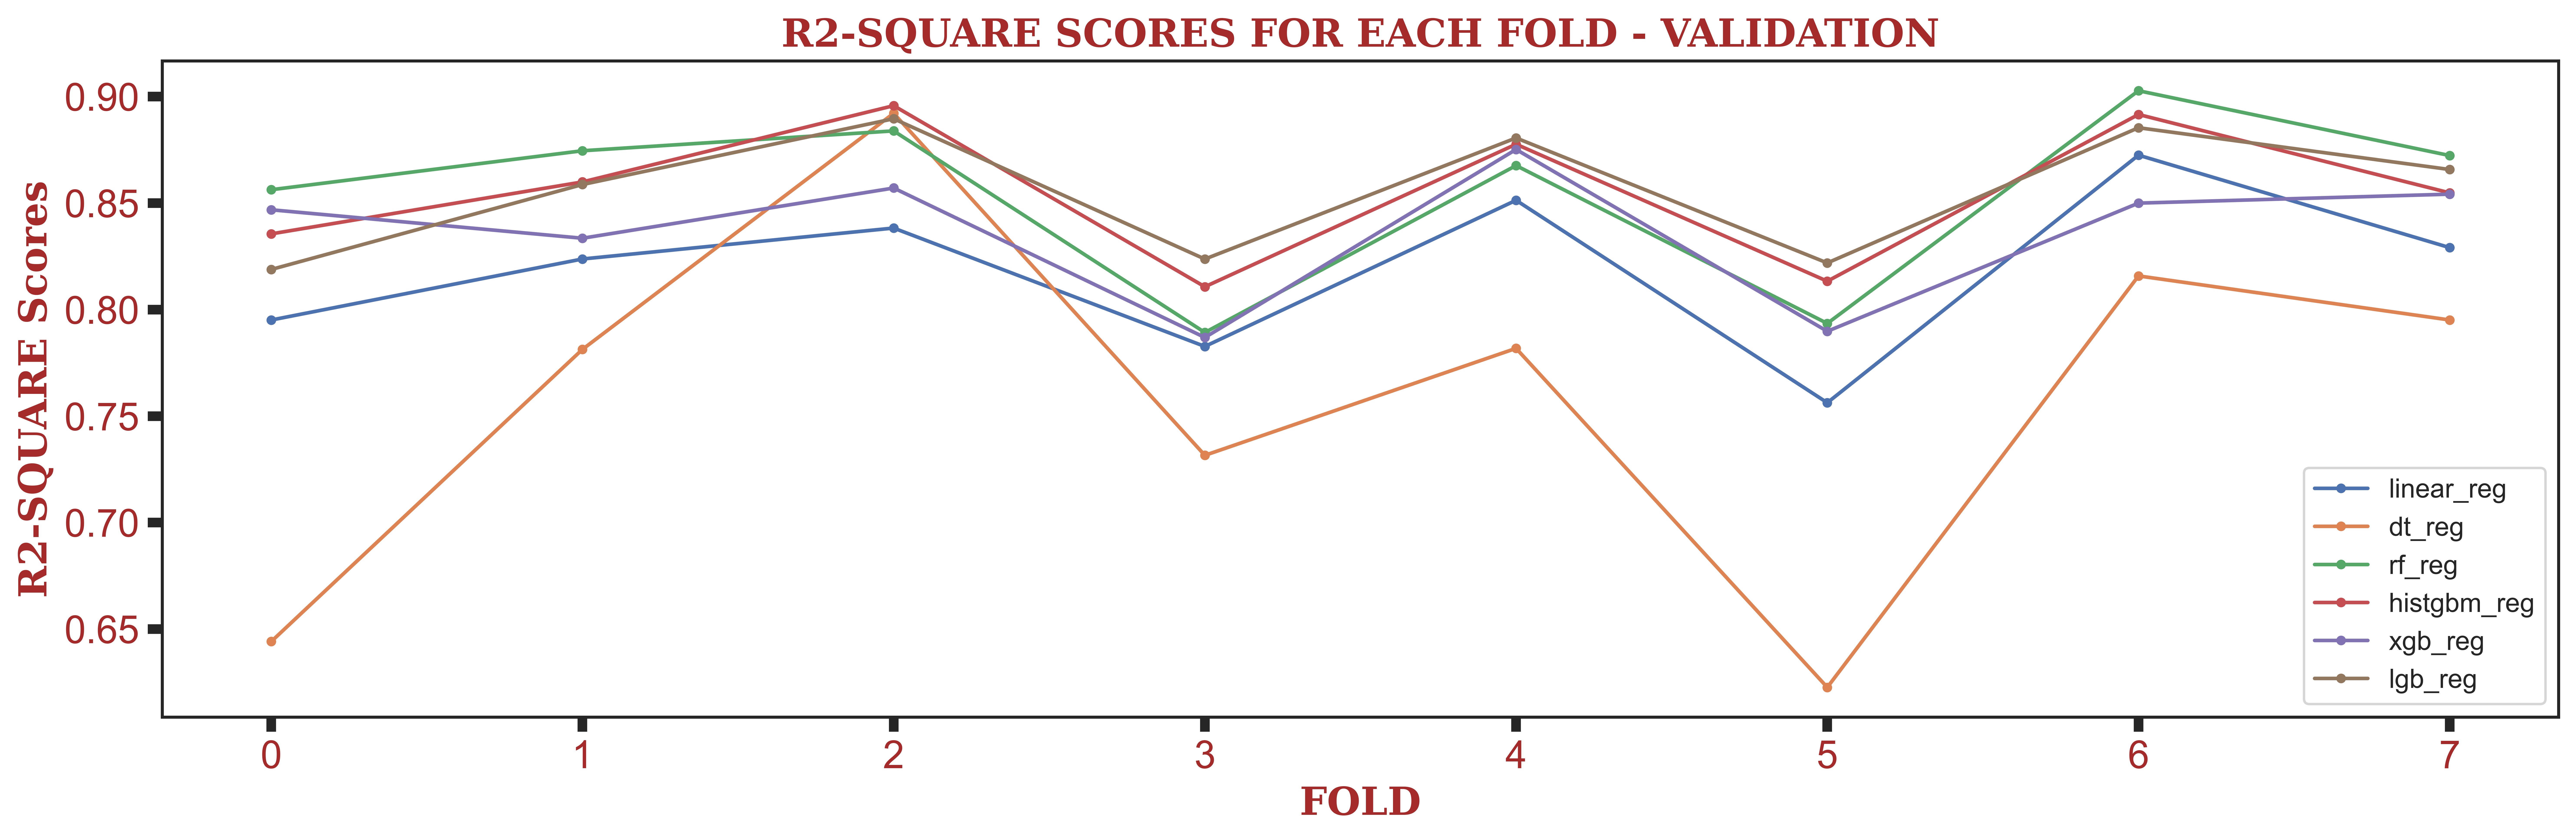

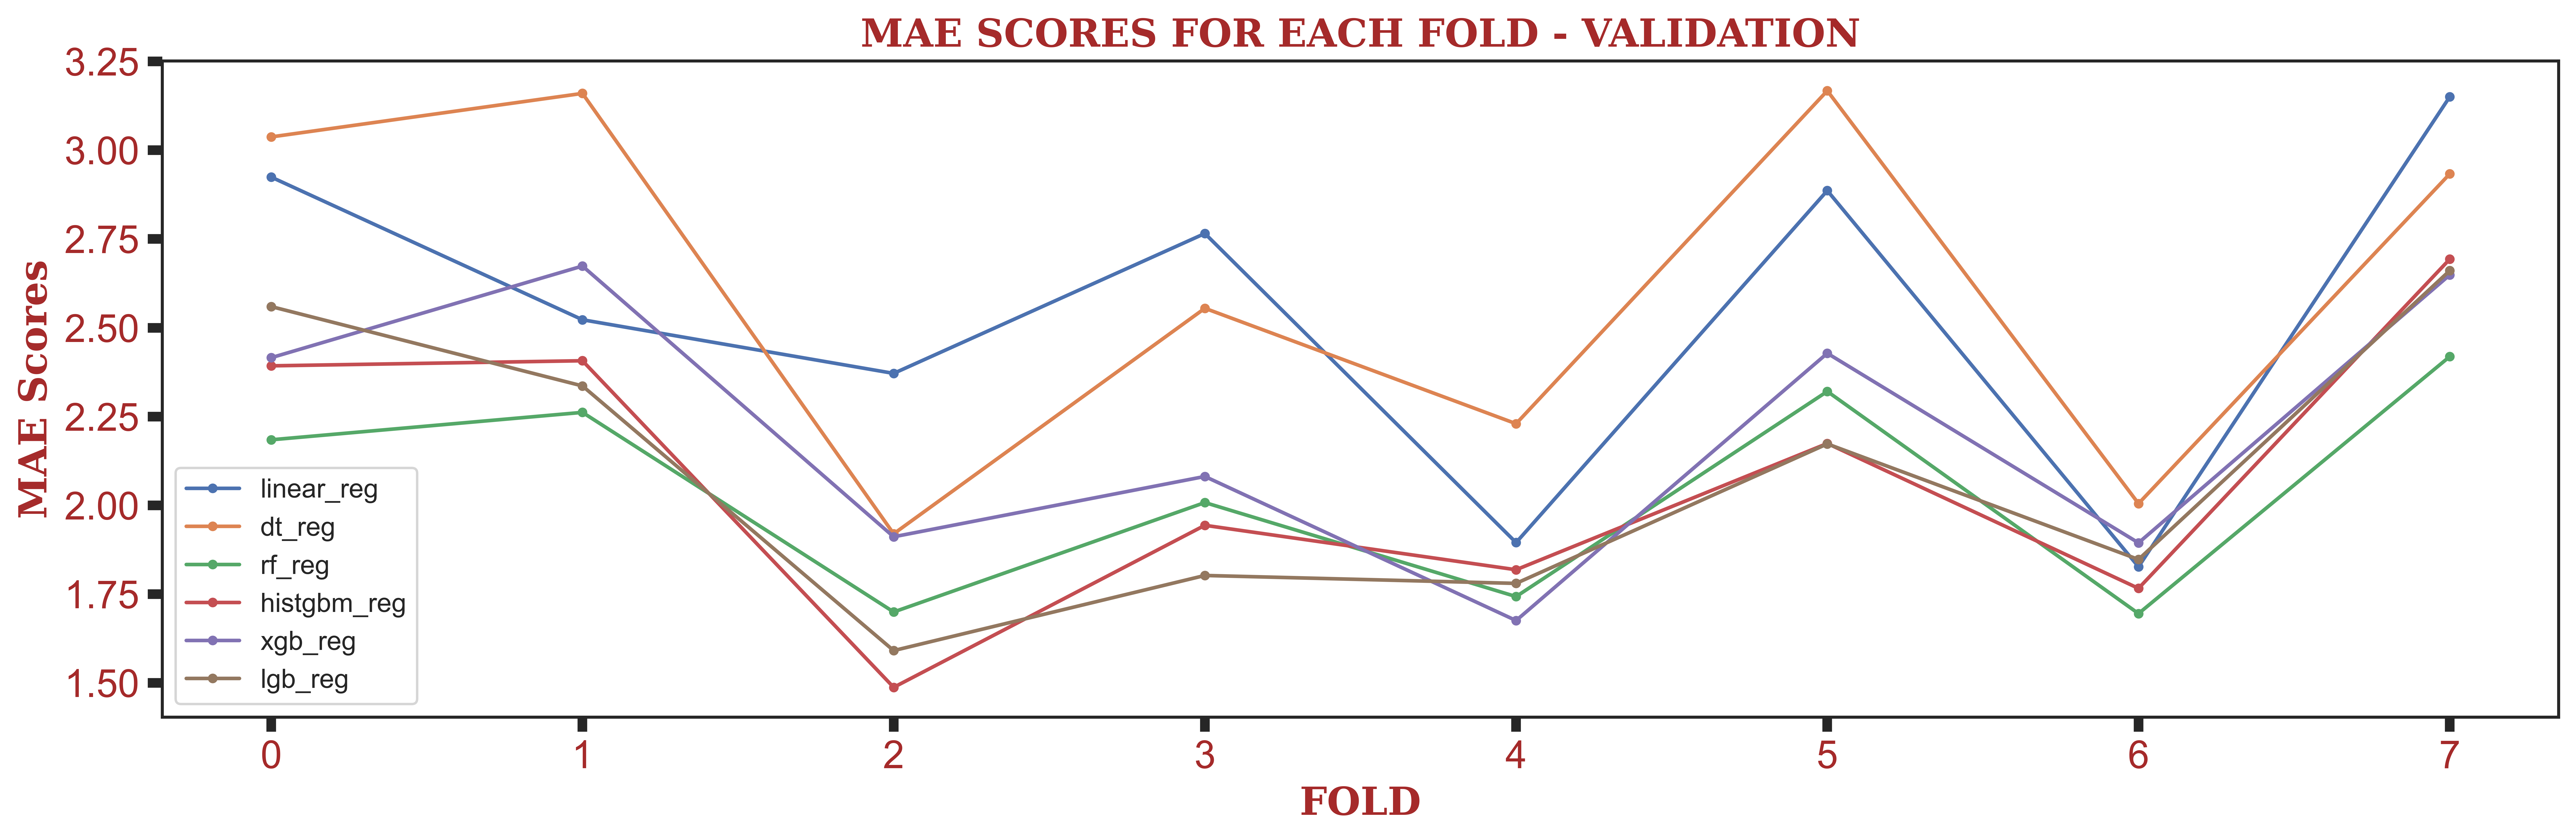

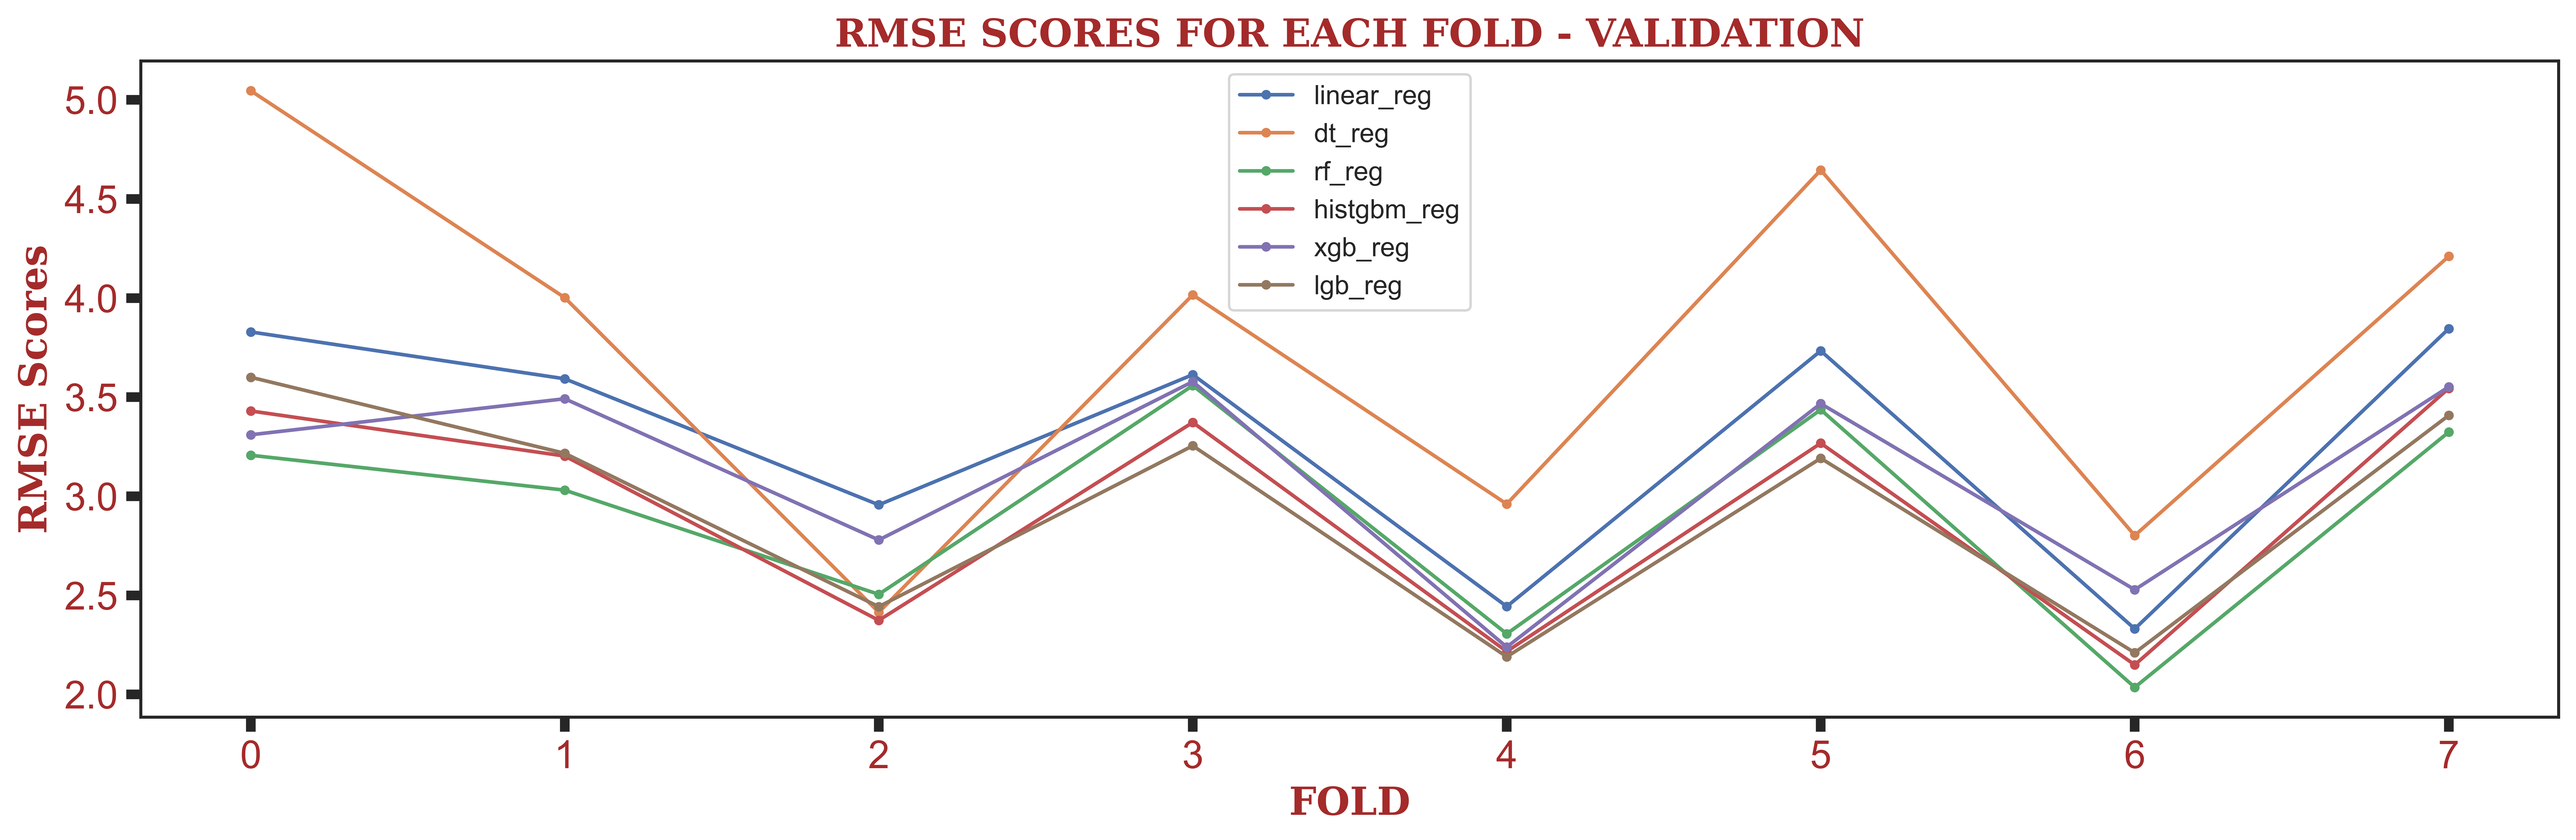

In [12]:
model_evaluation(model_score=model_score, N_SPLITS=N_SPLITS, idx=0)
model_evaluation(model_score=model_score, N_SPLITS=N_SPLITS, idx=1)
model_evaluation(model_score=model_score, N_SPLITS=N_SPLITS, idx=2)

In [13]:
best_model_name = 'rf_reg'
loaded_model = pickle_model(trained_models=trained_models[best_model_name],
                             directory='models',
                             pickle_name='model_file',
                             use='pickle')

c:\Users\91981\Desktop\GREAT LEARNING\FROM SCRATCH LEARNING\PROJETCS\regression_car_mpg_sample_project\models
--------------------------------------------------------------------------------
Directory with models name created
--------------------------------------------------------------------------------
Model file pickled & SAVED in directory models/model_file.pkl
pickle file named model_file LOADED
--------------------------------------------------------------------------------


In [14]:
train_preds_final = np.zeros(len(train_X))
for model in loaded_model:
    train_preds_final+=model.predict(train_X)/N_SPLITS
print(metrics.r2_score(train_y,train_preds_final))


test_preds_final = np.zeros(len(X_test))
for model in loaded_model:
    test_preds_final+=model.predict(X_test)/N_SPLITS
print(metrics.r2_score(y_test,test_preds_final))

0.9715935872657938
0.9200303414443791


In [15]:
best_model_name

'rf_reg'

In [18]:
regression_plot(train_y, train_preds_final, best_model_name=best_model_name)

In [20]:
error_plot(train_y, train_preds_final, best_model_name=best_model_name)